Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 05-May-2025

In [3]:
import pandas as pd
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

In [1]:
# Set data directory 
data_dir = r'Z:/Data/Roadrunner/GtACR_arena/'

In [51]:
# Load data
df = pd.read_csv(data_dir+'roadrunner.csv') 
df

,set,intensity,animal_id,frame,time,n_stimulus,x,y,forward_velocity,lateral_velocity,angular_velocity,speed
0,1,1,1,1,0.05,0,28.2,53.1,2.120862,1.871349e+00,0.000000e+00,2.828427
1,1,1,1,2,0.10,0,28.3,53.2,3.000000,2.000000e+00,-7.152669e+01,3.605551
2,1,1,1,3,0.15,0,28.5,53.3,6.471832,1.765045e+00,2.261986e+02,6.708204
3,1,1,1,4,0.20,0,28.9,53.5,8.021235,8.122769e-01,2.530511e+02,8.062258
4,1,1,1,5,0.25,0,29.2,53.7,7.235294,2.941176e+00,8.219996e+01,7.810250
...,...,...,...,...,...,...,...,...,...,...,...,...
2690995,2,9,295,13796,689.80,0,55.7,53.6,8.148217,-1.267500e+00,-5.807638e+01,8.246211
2690996,2,9,295,13797,689.85,0,55.8,53.9,5.341609,-3.530894e+00,-3.559440e-12,6.403124
2690997,2,9,295,13798,689.90,0,56.1,54.1,7.000000,-3.000000e+00,1.038886e+02,7.615773
2690998,2,9,295,13799,689.95,0,56.1,54.6,9.928768,1.191452e+00,-1.368555e+02,10.000000


In [25]:
# Pool time courses for a given intensity
intensity = 9
df_sub = df[df.intensity==intensity]

stimulus_duration = 10 # s
pre_duration = 5 # s
post_duration = 5 # s
sampling_rate = 20 # Hz
filter_size = 0.2 # s

animal_ids = df_sub.animal_id.unique().tolist()

# Initialize variables
mean_speeds = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(animal_ids)))
mean_intensities = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(animal_ids)))

# Loop over animals
for animal_id_index, animal_id in enumerate(animal_ids):
    n_stimulus = df_sub.n_stimulus[df_sub.animal_id==animal_id].to_numpy()
    speed = df_sub.speed[df_sub.animal_id==animal_id].to_numpy()
    intensity = df_sub.intensity[df_sub.animal_id==animal_id].to_numpy()
    
    stimulus_onset_indices = np.argwhere(np.diff(n_stimulus)>0)+1
    
    mean_speed = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(stimulus_onset_indices)))
    mean_intensity = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(stimulus_onset_indices))) 

    # Loop over stimulus presentations
    for index, _ in enumerate(stimulus_onset_indices):
        onset = stimulus_onset_indices[index][0]-pre_duration*sampling_rate
        offset = stimulus_onset_indices[index][0]+(stimulus_duration+post_duration)*sampling_rate
        mean_speed[:,index] = ndimage.median_filter(speed[onset:offset], size=int(filter_size*sampling_rate))
        mean_intensity[:,index] = intensity[onset:offset]
        
    mean_speeds[:,animal_id_index] = np.mean(mean_speed,axis=1) 
    mean_intensities[:,animal_id_index] = np.mean(mean_intensity,axis=1) 

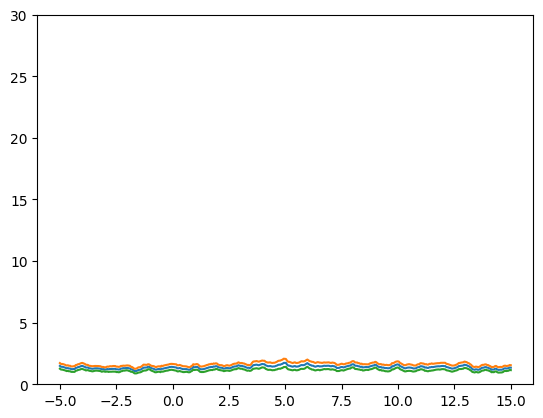

In [26]:
# Plot time courses
time = time = np.linspace(-pre_duration, stimulus_duration+post_duration, num=(pre_duration+stimulus_duration+post_duration)*sampling_rate)
mean = np.mean(mean_speeds,axis=1)
sem = np.std(mean_speeds,axis=1)/np.sqrt(np.size(mean_speeds,1))

plt.plot(time,mean)
plt.plot(time,mean+sem)
plt.plot(time,mean-sem)
plt.ylim([0,30])
# plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()

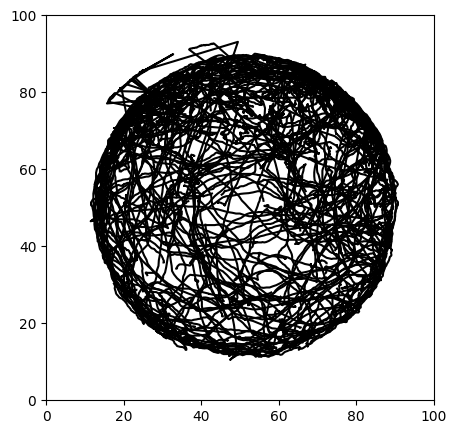

In [439]:
# Plot trajectories for an intensity 
# Note: Different sets can have different absolute x/y values. Plot separately.
intensity = 9
sets = [1]

df_sub = df[(df.intensity==intensity) & (df.set.isin(sets))] 
animal_ids = df_sub.animal_id.unique().tolist()

fig, ax = plt.subplots(figsize=(5, 5))
for animal_id in animal_ids:
    x = df_sub["x"][(df_sub.animal_id==animal_id)].to_numpy() 
    y = df_sub["y"][(df_sub.animal_id==animal_id)].to_numpy() 
    n_stimulus = df_sub["n_stimulus"][(df_sub.animal_id==animal_id)].to_numpy() 
    stimulus_onset_indices = np.argwhere(np.diff(n_stimulus)>0)+1
    
    onset = stimulus_onset_indices[0][0]
    # ax.plot(x[:onset], y[:onset], color=[0,0,0])

    # Loop over stimulus presentations
    for index, _ in enumerate(stimulus_onset_indices):
        onset = stimulus_onset_indices[index][0]
        offset = onset+(stimulus_duration)*sampling_rate
                
        # if index<len(stimulus_onset_indices)-1:
        #     next_onset = stimulus_onset_indices[index+1][0]
        # else:
        #     next_onset = len(x)
        
        ax.plot(x[onset:offset], y[onset:offset], color=[0,0,0])
        # ax.plot(x[offset:next_onset], y[offset:next_onset], color=[0,0,0])

ax.set_xlim(0,100)
ax.set_ylim(0,100)
# plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()

In [28]:
# Calculate mean speed for each animal and intensity
sampling_rate = 20 # Hz
filter_size = 0.2 # s
sets = [1,2]

intensities = df.intensity.unique().tolist() 

# Initialize variables 
n_animals = len(df.animal_id[(df.intensity==intensities[0]) & (df.set.isin(sets))].unique().tolist())
mean_speeds = np.empty((n_animals,len(intensities)))
mean_speeds[:] = np.nan

# Loop over intensities
for intensity_index, intensity in enumerate(intensities):
    df_sub = df[(df.intensity==intensity) & (df.set.isin(sets))]
    animal_ids = df_sub.animal_id.unique().tolist()

    # Loop over animals
    for animal_id_index, animal_id in enumerate(animal_ids):
        speed = df_sub.speed[(df_sub.animal_id==animal_id) & (df_sub.n_stimulus!=0)].to_numpy()
        speed = ndimage.median_filter(speed, size=int(filter_size*sampling_rate))
        speed = np.mean(speed)

        mean_speeds[animal_id_index,intensity_index] = speed

In [29]:
n_animals

40

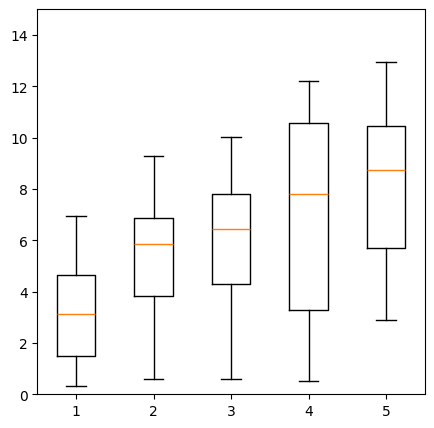

In [30]:
# Plot speed over intensity
fig, ax = plt.subplots(figsize=(5, 5))

plt.boxplot(mean_speeds, positions=[1,2,3,4,5])

ax.set_ylim(0,15)
plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()

In [52]:
# Calculate mean speed for each animal and repetition for a specific intensity
intensity = 1
stimulus_duration = 10 # s
sampling_rate = 20 # Hz
filter_size = 0.2 # s

# Initialize variables
df_sub = df[df.intensity==intensity]
animal_ids = df_sub.animal_id.unique().tolist()
n_animals = len(animal_ids)
n_stimulus_presentations = len(df_sub.n_stimulus[df_sub.n_stimulus!=0].unique().tolist())
mean_speeds = np.zeros((n_animals, n_stimulus_presentations))

# Loop over animals
for animal_id_index, animal_id in enumerate(animal_ids):
    n_stimulus = df_sub.n_stimulus[df_sub.animal_id==animal_id].to_numpy()
    stimulus_onset_indices = np.argwhere(np.diff(n_stimulus)>0)+1
    speed = df_sub.speed[df_sub.animal_id==animal_id].to_numpy()
    
    # Loop over stimulus presentations
    for index, _ in enumerate(stimulus_onset_indices):
        onset = stimulus_onset_indices[index][0]
        offset = stimulus_onset_indices[index][0]+stimulus_duration*sampling_rate
        mean_speeds[animal_id_index,index] = np.mean(ndimage.median_filter(speed[onset:offset], size=int(filter_size*sampling_rate)))

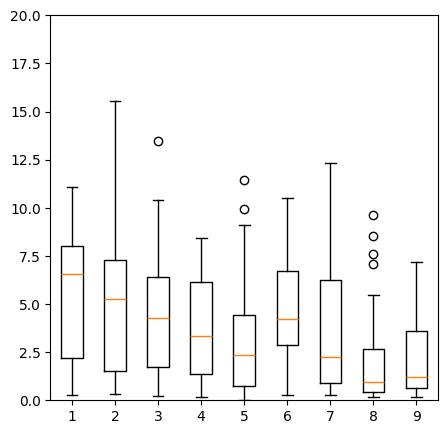

In [56]:
# Plot speed over stimulus repetition
fig, ax = plt.subplots(figsize=(5, 5))

plt.boxplot(mean_speeds, positions=[1,2,3,4,5,6,7,8,9])

ax.set_ylim(0,20)
# plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()